In [1]:
import torch.optim as optim
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageFile
from glob import glob
#from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

from torchvision import datasets
import torchvision.transforms as transforms
import torchvision.models as models

from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

batch_size = 60
num_workers = 0
num_labels = 3

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('Use CUDA: {}'.format(use_cuda))
torch.cuda.init()
print(torch.cuda.cudaStatus())
print(torch.cuda.device_count())
for device in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(device))
    print(torch.cuda.get_device_capability(device))
    print(torch.cuda.get_device_properties(device))
    print('')
#GET RID OF "Image file truncated ERROR from PIL"
ImageFile.LOAD_TRUNCATED_IMAGES = True

Use CUDA: True
1
GeForce RTX 2080
(7, 5)
_CudaDeviceProperties(name='GeForce RTX 2080', major=7, minor=5, total_memory=7944MB, multi_processor_count=46)



In [2]:
# helper function to un-normalize and display an image
def imshow(img):
    """ Display a numpy-array as an image. """

    img = img.squeeze()
    img = img.transpose(1, 2, 0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array(
        (0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    plt.imshow(img)

    #img = img / 2 + 0.5  # unnormalize
    #plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [3]:
# obtain one batch of training images
def showOneIter(loader):
    dataiter = iter(loader)

    images, labels = dataiter.next()
    images = images.numpy()  # convert images to numpy for display

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(8):
        ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
        imshow(images[idx])
        #ax.set_title(classes[labels[idx]])

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path,
          model_arch_name, valid_loss_old, epoch_old = 1):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_old
    batch_idx = 0

    for epoch in range(epoch_old+1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0.0
        total = 0.00000001

        ###################
        # train the model #
        ###################
        model.train()
        #        try:
        #print('train')
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            torch.set_grad_enabled(True)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + (
                (1 / (batch_idx + 1)) * (loss.data - train_loss))


#        except Exception as e:
#            print('Except eval {} - batch_idx={}'.format(e, batch_idx))
#            if use_cuda:
#                torch.cuda.empty_cache()
######################
# validate the model #
######################
#        if use_cuda:
#            torch.cuda.empty_cache()

        model.eval()
        try:
            #print('eval')
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                torch.set_grad_enabled(False)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss
                valid_loss = valid_loss + (
                    (1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(
                np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.detach().size(0)

        except Exception as e:
            print('Except eval {} - batch_idx={}'.format(e, batch_idx))
            if use_cuda:
                torch.cuda.empty_cache()

        # print training/validation statistics
        print(
            'Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.1f}% ({}/{})'
            .format(epoch, train_loss, valid_loss, 100. * correct / total,
                    correct, total))

        #print('\nAccuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

        ## TODO: save the model if validation loss has decreased
        if ((epoch >= 0) and (valid_loss <= valid_loss_min)):
            print(
                'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                .format(valid_loss_min, valid_loss))
            torch.save({
                'epoch': epoch + 1,
                'arch': model_arch_name,
                'state_dict': model.state_dict(),
                'valid_loss': valid_loss,
                'optimizer': optimizer.state_dict(),
            }, save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model

In [5]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + (
            (1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(
            np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total,
                                                correct, total))

In [6]:
transform = transforms.Compose([
    transforms.RandomRotation(180),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  # randomly flip and rotate
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# choose the training and test datasets
train_data = datasets.ImageFolder('../data/train', transform=transform)
test_data = datasets.ImageFolder('../data/test', transform=test_transform)
valid_data = datasets.ImageFolder('../data/valid', transform=transform)

datasets_transfer = {
    "train": train_data,
    "valid": valid_data,
    "test": test_data
}

# obtain training indices that will be used for validation

train_idx = list(range(len(train_data)))
valid_idx = list(range(len(valid_data)))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers)

loaders_transfer = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

In [7]:
def infer(img_path):

    class_names = [item for item in datasets_transfer['train'].classes]
    #print(class_names)
    img_pil = Image.open(img_path)
    #img = img.convert('RGB')
    #imgplot = plt.imshow(img_pil)
    #plt.show(img_pil)
    print(img_path)
    img_tensor = test_transform(img_pil)
    if (img_tensor.shape[0] == 4):
        img_pil = img_pil.convert('RGB')
        img_tensor = test_transform(img_pil)
    img_tensor.unsqueeze_(0)  #???? VGG! ResNet??
    img_variable = Variable(img_tensor, requires_grad=True)

    if (use_cuda):
        model = model_transfer.to('cpu')
    outputs = model_transfer(img_variable)
    #pred = outputs.data.max(1, keepdim=True)[1]
    prob, preds = torch.max(outputs, 1)
    if (use_cuda):
        model = model_transfer.to('cuda')
    
    return class_names[preds.numpy()[0]]valid_loss_old = checkpoint['valid_loss']

In [8]:
def infer_direct(img):

    class_names = [item for item in datasets_transfer['train'].classes]
    #print(class_names)
    img_pil = img
    #img = img.convert('RGB')
    #imgplot = plt.imshow(img_pil)
    #plt.show(img_pil)

    img_tensor = test_transform(img_pil)
    if (img_tensor.shape[0] == 4):
        img_pil = img_pil.convert('RGB')
        img_tensor = test_transform(img_pil)
    img_tensor.unsqueeze_(0)  #???? VGG! ResNet??
    img_variable = Variable(img_tensor, requires_grad=True)

    if (use_cuda):
        model = model_transfer.to('cpu')
    
    outputs = model_transfer(img_variable)
    #prob, preds = outputs.data.max(1, keepdim=True)
    prob, preds = torch.max(outputs, 1)
    if (use_cuda):
        model = model_transfer.to('cuda')

    print(outputs)
    print(preds)
    return class_names[preds.numpy()[0]]

In [9]:
model_transfer = models.densenet201(pretrained=True)
# None
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

# Switch to the classifier we need for the flower example
classifier = nn.Sequential(
    OrderedDict([
        ('fc1', nn.Linear(1920, 1024)),
        ('dropout1', nn.Dropout(0.2)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(1024, 512)),
        ('dropout2', nn.Dropout(0.2)),
        ('relu', nn.ReLU()),
        ('output', nn.Linear(512, num_labels)),
        #('output', nn.LogSoftmax(dim=1))
    ]))

model_transfer.classifier = classifier

if use_cuda:
    model_transfer = model_transfer.to('cuda')

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
criterion_transfer = nn.CrossEntropyLoss()
#optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.0001, momentum=0.9)
#ptimizer_transfer = optim.Adagrad(model_transfer.parameters(), lr=0.05, lr_decay=0.01, weight_decay=0, initial_accumulator_value=0)
ptimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.00020, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

In [35]:
# load the model that got the best validation accuracy
checkpoint = torch.load('model_skincancer.pt')
model_transfer.load_state_dict(checkpoint['state_dict'])
print('The VALID loss saved was: {}'.format(checkpoint['valid_loss']))
print('And numer of epochs run was: {}'.format(checkpoint['epoch']))
optimizer_transfer.load_state_dict(checkpoint['optimizer'])
model_transfer.to('cuda')
print('')
valid_loss_old = checkpoint['valid_loss']
epoch_old = checkpoint['epoch']

The VALID loss saved was: 0.7324249148368835
And numer of epochs run was: 129



In [34]:
'''
torch.save({
    'epoch': 129,
    'arch': 'densenet201_skincancer',
    'state_dict': model_transfer.state_dict(),
    'valid_loss': 0.7324249148368835,
    'optimizer': optimizer_transfer.state_dict(),}, 'model_skincancer.pt')
'''


In [32]:
# train the model

# set loss to inf first train session...
# valid_loss_old = np.inf
model_transfer.cuda()
model_transfer = train(500, loaders_transfer, model_transfer,
                       optimizer_transfer, criterion_transfer, use_cuda,
                       'model_skincancer.pt', 'densenet201_skincancer', valid_loss_old, epoch_old)

# load the model that got the best validation accuracy (uncomment the line below)
checkpoint = torch.load('model_skincancer.pt')
model_transfer.load_state_dict(checkpoint['state_dict'])
valid_loss_old = checkpoint['valid_loss']
epoch_old = checkpoint['epoch']

Epoch: 1 	Training Loss: 0.781401 	Validation Loss: 0.867939 	Accuracy: 66.7% (28.0/42.00000001)
Epoch: 2 	Training Loss: 0.769726 	Validation Loss: 0.837206 	Accuracy: 61.9% (26.0/42.00000001)
Validation loss decreased (0.840992 --> 0.837206).  Saving model ...
Epoch: 3 	Training Loss: 0.806054 	Validation Loss: 0.862421 	Accuracy: 69.0% (29.0/42.00000001)
Epoch: 4 	Training Loss: 0.785533 	Validation Loss: 0.831326 	Accuracy: 71.4% (30.0/42.00000001)
Validation loss decreased (0.837206 --> 0.831326).  Saving model ...
Epoch: 5 	Training Loss: 0.756256 	Validation Loss: 0.815530 	Accuracy: 66.7% (28.0/42.00000001)
Validation loss decreased (0.831326 --> 0.815530).  Saving model ...
Epoch: 6 	Training Loss: 0.798950 	Validation Loss: 0.870624 	Accuracy: 50.0% (21.0/42.00000001)
Epoch: 7 	Training Loss: 0.789284 	Validation Loss: 0.866143 	Accuracy: 52.4% (22.0/42.00000001)
Epoch: 8 	Training Loss: 0.788477 	Validation Loss: 0.838906 	Accuracy: 64.3% (27.0/42.00000001)
Epoch: 9 	Trainin

KeyboardInterrupt: 

In [36]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.857585


Test Accuracy: 58% (348/600)


In [37]:
def between(value, a, b):
    # Find and validate before-part.
    pos_a = value.find(a)
    if pos_a == -1: return ""
    # Find and validate after part.
    pos_b = value.rfind(b)
    if pos_b == -1: return ""
    # Return middle part.
    adjusted_pos_a = pos_a + len(a)
    if adjusted_pos_a >= pos_b: return ""
    return value[adjusted_pos_a:pos_b]


def before(value, a):
    # Find first part and return slice before it.
    pos_a = value.find(a)
    if pos_a == -1: return ""
    return value[0:pos_a]


def after(value, a):
    # Find and validate first part.
    pos_a = value.rfind(a)
    if pos_a == -1: return ""
    # Returns chars after the found string.
    adjusted_pos_a = pos_a + len(a)
    if adjusted_pos_a >= len(value): return ""
    return value[adjusted_pos_a:]

In [38]:
# Now we let the GPU do full weight adjustments when the classifier layer have 
# been somewhat calibrated to a pretrained net, 
# e.g. accuracy on test set > 60-70% and epochs>10...
# THIS WE DO BY SETTING:
# requires_grad_toggle(model_transfer, 'feature', True)

def requires_grad_toggle(model, param_name, flag):
    for param in model.parameters():
        if (before(param_name, ".") == param_name):
            param.requires_grad = flag


#requires_grad_toggle(model_transfer, 'feature', True)
requires_grad_toggle(model_transfer, 'feature', False)




NEW IMAGE 


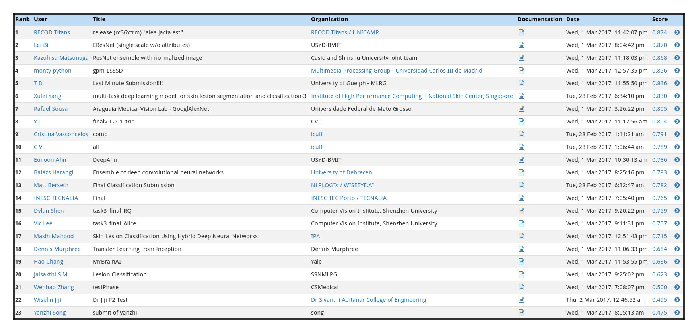

images/cat_1.jpeg



NEW IMAGE 


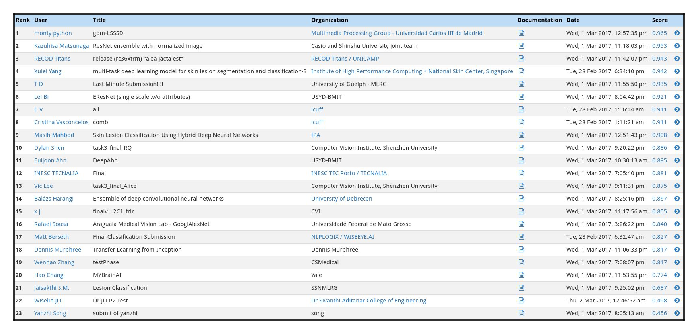

images/cat_2.jpeg



NEW IMAGE 


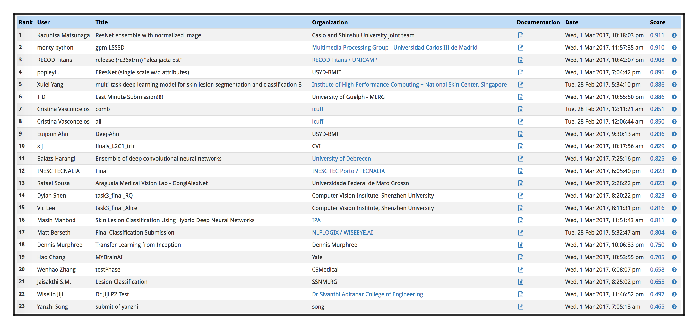

images/cat_3.png



NEW IMAGE 


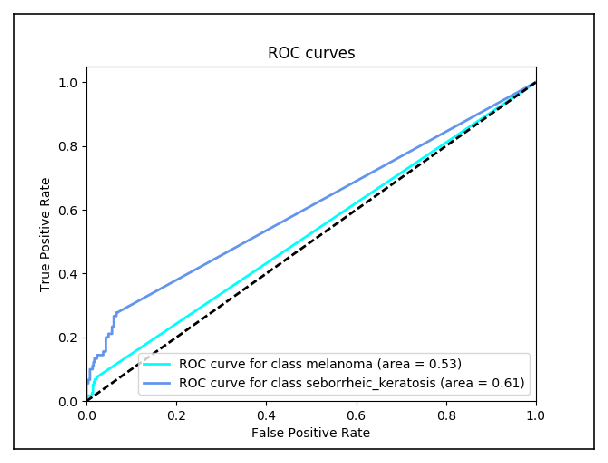

images/sample_ROC_curve.png



NEW IMAGE 


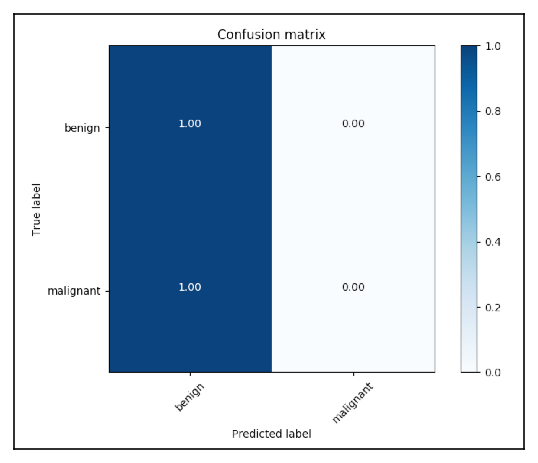

images/sample_confusion_matrix.png



NEW IMAGE 


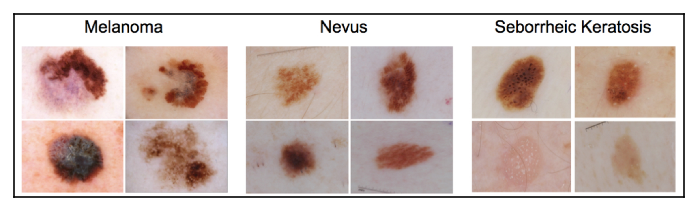

images/skin_disease_classes.png


In [39]:
import glob
for i in glob.iglob('images/*'):
    print("\n\n")
    print("NEW IMAGE ")

    img = Image.open(i)

    imgplot = plt.imshow(img)

    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

    plt.show()
    infer(i)

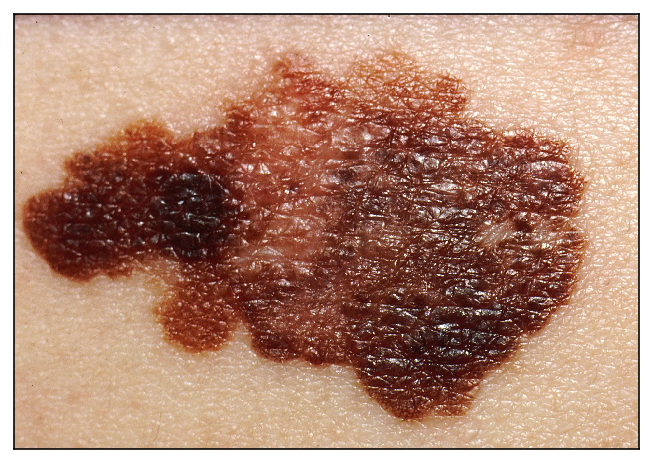

tensor([[-0.1922,  0.5566, -0.2291]], grad_fn=<ThAddmmBackward>)
tensor([1])


'nevus'

In [40]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get(
    #'https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/articles/health_tools/precancerous_lesions_slideshow/dermnet_photo_of_actinic_keratosis.jpg',
    #'https://www.aad.org/Image%20Library/Main%20navigation/Public%20and%20patients/Diseases%20and%20treatments/Bumps%20and%20growths/seborrheic-keratosis_landing.jpg'
    #'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Melanoma.jpg/300px-Melanoma.jpg'
    #'https://images.homedepot-static.com/productImages/d31251a7-fcd6-4614-8608-a27d38496abd/svn/white-roommates-wall-decals-rmk1512gm-64_1000.jpg'
    'https://upload.wikimedia.org/wikipedia/commons/thumb/6/6c/Melanoma.jpg/1920px-Melanoma.jpg'
)
img = Image.open(BytesIO(response.content))

imgplot = plt.imshow(img)

imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)

plt.show()
infer_direct(img)

In [41]:
    class_names = [
        item for item in datasets_transfer['train'].classes
    ]


In [42]:
print(class_names)

['melanoma', 'nevus', 'seborrheic_keratosis']


In [117]:
import csv

def minitest(loader, model, criterion, use_cuda, writer):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        #print(loader.dataset.imgs[batch_idx][0])
        if use_cuda:
            data = data.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        probs = (torch.exp(output.data.to('cpu')[0])/torch.sum(torch.exp(output.data.to('cpu')[0]))).numpy()
        melanoma = probs[0]
        seborrheic = probs[2]
        writer.writerow([loader.dataset.imgs[batch_idx][0], melanoma, seborrheic])
        
minitest_data = datasets.ImageFolder('../data/test', transform=test_transform)
with open('predictions.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Id','task_1','task_2'])
    minitest_loader = torch.utils.data.DataLoader(minitest_data, batch_size=1, num_workers=num_workers)
    minitest(minitest_loader, model_transfer, criterion_transfer, use_cuda, spamwriter)

In [95]:
import csv
with open('eggs.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['Spam'] * 5 + ['Baked Beans'])
    spamwriter.writerow(['Spam', 'Lovely Spam', 'Wonderful Spam'])